# Random picking

http://rdkit.blogspot.co.uk/2014/08/picking-diverse-compounds-from-large.html

In [1]:
from itertools import chain, combinations

from collections import OrderedDict as odict

from math import ceil

import warnings

import seaborn as sns

## Config

In [2]:
# Fraction of data to take as test set...

test_fraction = 1/4

# Number of times to repeat model-building/prediction process...

n_repeats = 1

In [3]:
# Ignore 'deprecation' warnings...

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [4]:
cfi = chain.from_iterable

sns.set()

In [5]:
# ChEMBL connection...

engine = create_engine(open('database.txt').read().strip())

## Reload  actives

In [6]:
# Active compounds ...

all_actives, all_mols = pd.read_pickle('actives.pkl')

all_actives.shape[0], all_actives['symbol'].unique().size, all_actives['usmiles'].unique().size, all_mols.shape[0]

(167055, 138, 104749, 104749)

In [7]:
# actives.head(1)

In [8]:
# active_mols.head(1)

## MCNB modelling results

In [9]:
# 1 = actives test set, 2 = inactives test set

all_results_1, all_results_2  = pickle.load(open('all_results.pkl', 'r'))

In [10]:
summary_1 = pd.concat([x.groupby('symbol').apply(lambda x: round(sum(x['predicted']) / len(x['predicted']), 3)).to_frame('fraction') for x in all_results_1], axis=1)\
    .apply(lambda x: pd.Series({'mean': np.mean(x), 'sd': np.sqrt(np.var(x))}), axis=1)

summary_2 = pd.concat([x.groupby('symbol').apply(lambda x: round(sum(x['predicted']) / len(x['predicted']), 3)).to_frame('fraction') for x in all_results_2], axis=1)\
    .apply(lambda x: pd.Series({'mean': np.mean(x), 'sd': np.sqrt(np.var(x))}), axis=1)

counts = all_results_1[0].groupby('symbol').apply(len).to_frame('N')

classes = pd.read_pickle('target_class_map.pkl')

summary = summary_1.merge(summary_2, suffixes=('_1', '_2'), left_index=True, right_index=True)\
    .merge(counts, left_index=True, right_index=True)\
    .merge(classes, left_index=True, right_index=True)\
    .sort()\
    .reset_index(drop=False)\

summary.shape

(138, 7)

In [11]:
summary.head()

,symbol,mean_1,sd_1,mean_2,sd_2,N,target_class
0,ABCB1,0.7827,0.023770,0.0146,0.011775,163,Transporter > Primary active transporter
1,ABCG2,0.8435,0.035018,0.0225,0.020402,67,Transporter > Primary active transporter
2,ABL1,0.6983,0.020160,0.0307,0.012736,241,Enzyme > Kinase > Protein Kinase
3,ACE,0.9830,0.012689,0.0040,0.006633,100,Enzyme
4,ACHE,0.8049,0.022919,0.0111,0.004482,476,Enzyme


In [27]:
summary.to_pickle('summary.pkl')

In [ ]:
def get_color_map(n_classes):

    n = int(round(n_classes/2))*2 # Round up to next even number for convenience
        
    color_map = plt.get_cmap('gist_rainbow')(np.linspace(0.0, 1.0, n))

    return color_map[list(chain.from_iterable(zip(range(0, int(n/2)), range(int(n/2), n))))[:n_classes]] # Return number requested

In [13]:
def do_barchart(df, col):
    
    df = df.sort(['target_class', 'symbol'])

    # Colour mapping...

    classes = df['target_class'].unique().tolist()

    class_numbers = [classes.index(x) for x in df['target_class']]

    color_map = get_color_map(len(classes))
    
    color = [color_map[x] for x in class_numbers]

    # Create Plot...

    fig, ax = plt.subplots()

    fig.set_size_inches(40, 10)

    x_positions = range(df.shape[0])

    bars = ax.bar(x_positions, df[col].tolist(), width=0.9, align='center', color=color)

    ax.set_xlim([x_positions[0]-0.5, x_positions[-1]+0.5])

    ax.set_xticks(x_positions)

    ax.tick_params(axis='both', direction='out')

    ax.set_xticklabels(df['symbol'].tolist(), rotation=45, ha='right', fontsize=8)

    ax.legend([bars[class_numbers.index(x)] for x in range(len(classes))], classes)

    plt.show()

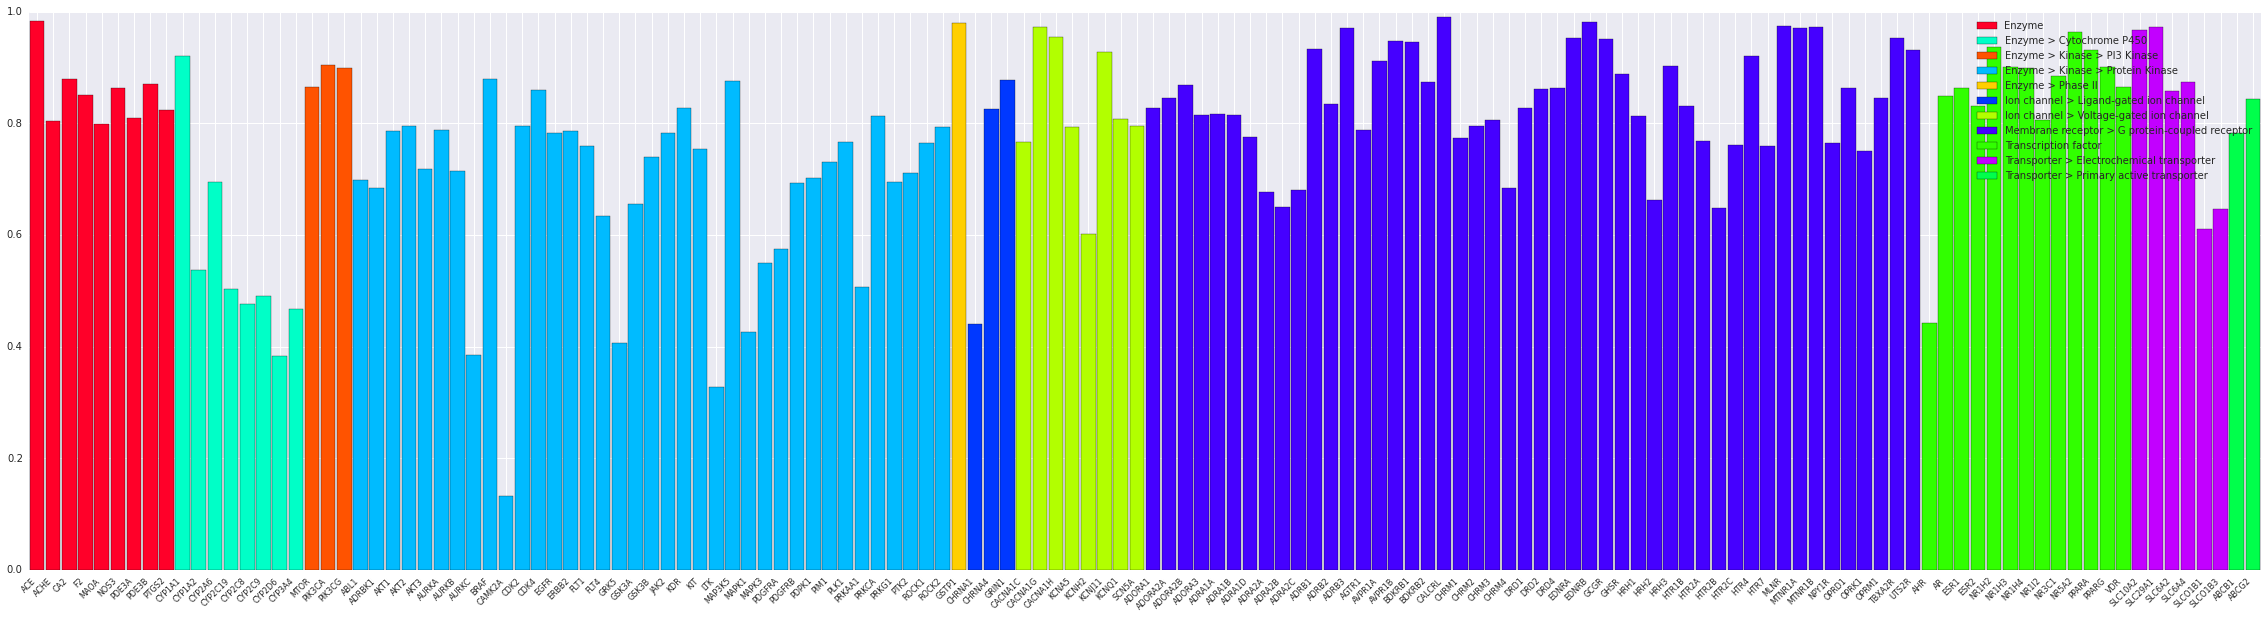

In [14]:
do_barchart(summary, 'mean_1')

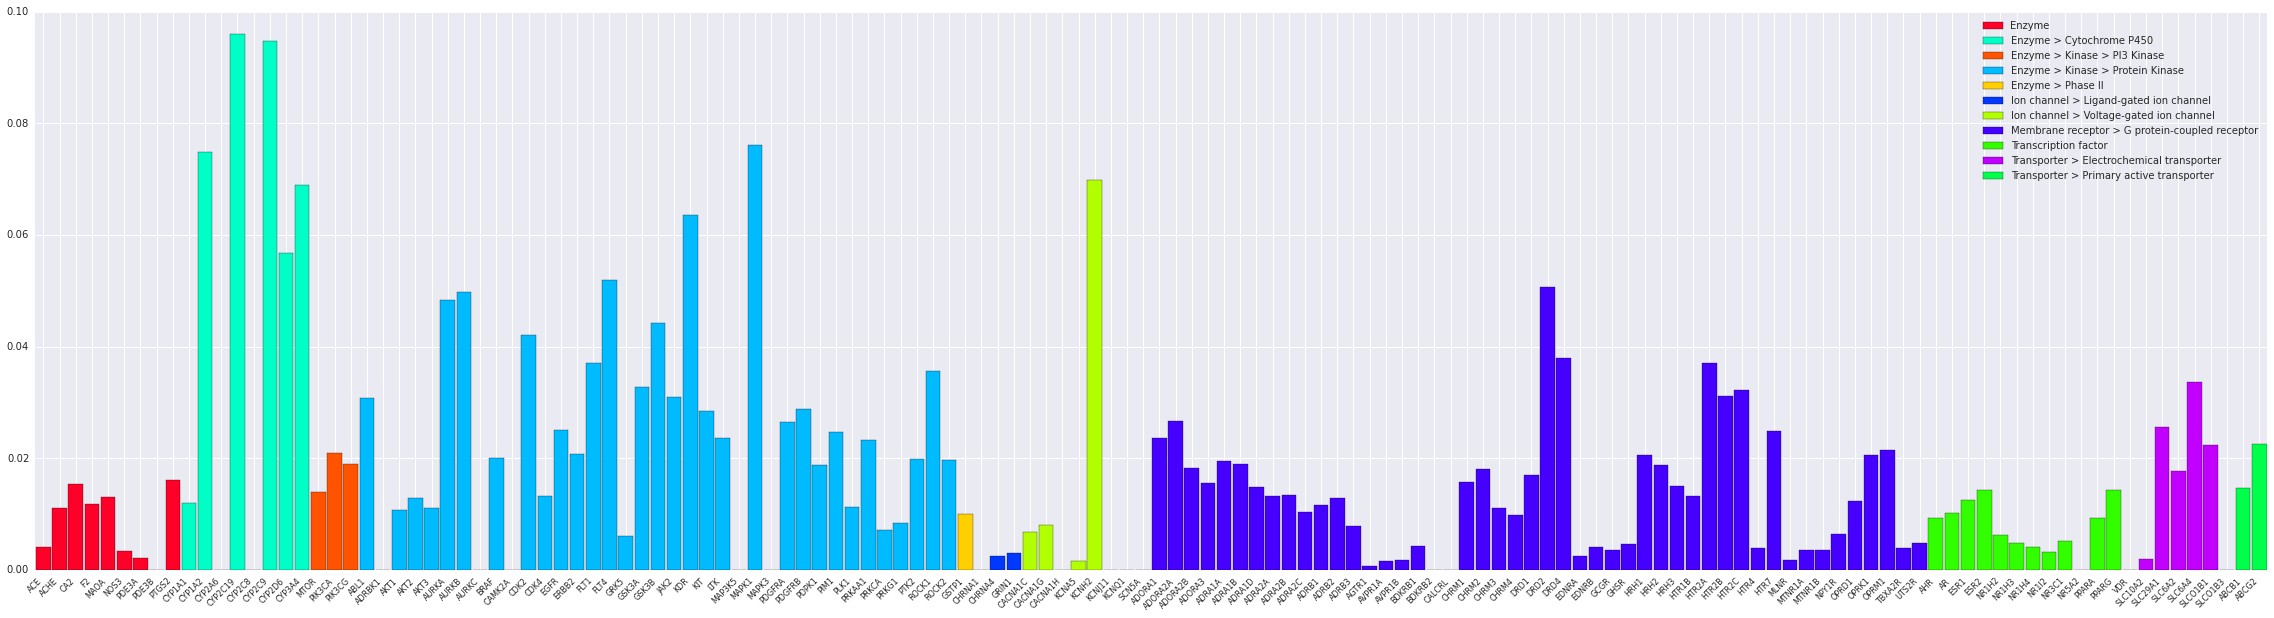

In [15]:
do_barchart(summary, 'mean_2')

In [16]:
# Colour mapping...

classes = sorted(summary['target_class'].unique().tolist())

class_numbers = [classes.index(x) for x in summary['target_class']]

color_map = get_color_map(len(classes))

color = [color_map[x] for x in class_numbers]

# Get subset of points for a target class...

def get_points(i, x):
    
    df = summary.query("target_class == @x")
    
    return axis.scatter(x=df[xcol], y=df[ycol], color=color_map[i], s=75)

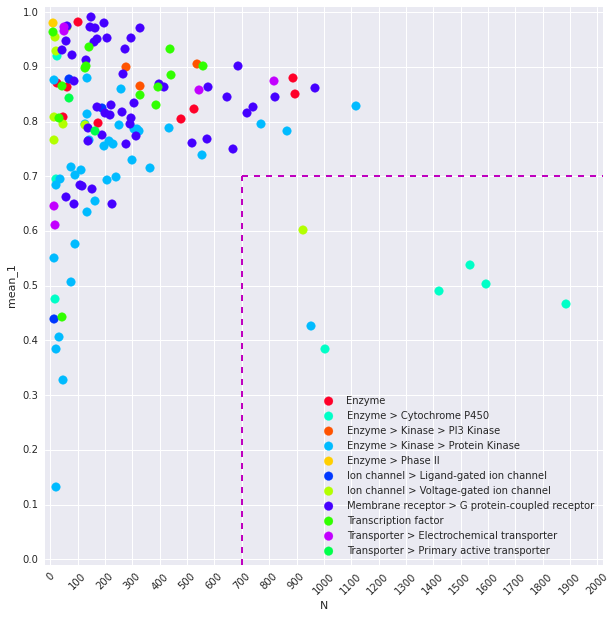

In [17]:
# Plot...

xcol, ycol = 'N', 'mean_1'
                                                         
fig, axis = plt.subplots(1, 1, figsize=(10, 10))

points = [get_points(i, x) for i, x in enumerate(classes)]

xticks = np.arange(0, 2100, 100)
axis.set_xlim(-20, 2020)
axis.set_xticks(xticks)
axis.set_xticklabels(xticks, rotation=45)
axis.set_xlabel(xcol)

yticks = np.arange(0, 1.1, 0.1)
axis.set_ylim(-0.01, 1.01)
axis.set_yticks(yticks)
axis.set_yticklabels(yticks)
axis.set_ylabel(ycol)

axis.legend(points, classes, scatterpoints=1, loc='lower right')

axis.plot((700, 700), (-0.01, 0.7), color='m', linestyle='--', linewidth=2)
axis.plot((700, 2020), (0.7, 0.7), color='m', linestyle='--', linewidth=2)

None

In [18]:
summary.query("N > 700 and mean_1 < 0.7").sort(['target_class', 'N'], ascending=[1, 0])

,symbol,mean_1,sd_1,mean_2,sd_2,N,target_class
54,CYP3A4,0.4675,0.011218,0.0690,0.005916,1887,Enzyme > Cytochrome P450
50,CYP2C19,0.5032,0.007756,0.0960,0.007211,1593,Enzyme > Cytochrome P450
48,CYP1A2,0.5375,0.015088,0.0748,0.004792,1535,Enzyme > Cytochrome P450
52,CYP2C9,0.4904,0.010180,0.0948,0.003600,1422,Enzyme > Cytochrome P450
53,CYP2D6,0.3837,0.010316,0.0567,0.008063,1003,Enzyme > Cytochrome P450
93,MAPK1,0.4262,0.011285,0.0761,0.007063,953,Enzyme > Kinase > Protein Kinase
85,KCNH2,0.6025,0.016219,0.0698,0.010477,922,Ion channel > Voltage-gated ion channel


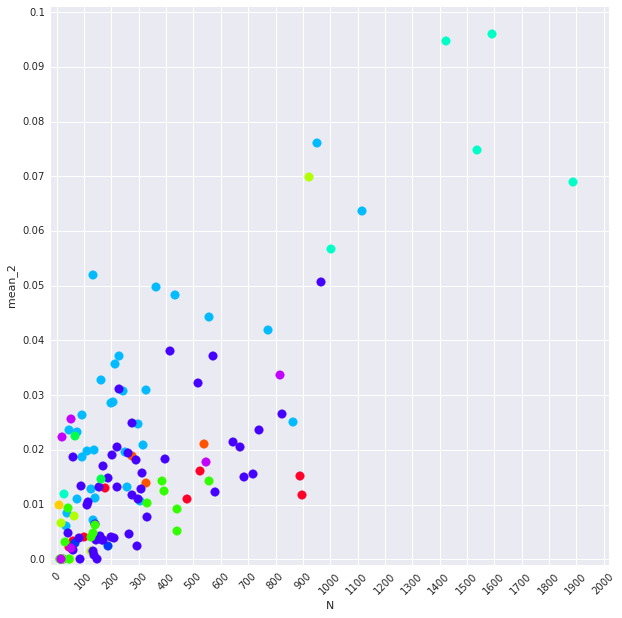

In [19]:
# Plot...

xcol, ycol = 'N', 'mean_2'
                                                         
fig, axis = plt.subplots(1, 1, figsize=(10, 10))

points = [get_points(i, x) for i, x in enumerate(classes)]

xticks = np.arange(0, 2100, 100)
axis.set_xlim(-20, 2020)
axis.set_xticks(xticks)
axis.set_xticklabels(xticks, rotation=45)
axis.set_xlabel(xcol)

yticks = np.arange(0, 0.11, 0.01)
axis.set_ylim(-0.001, 0.101)
axis.set_yticks(yticks)
axis.set_yticklabels(yticks)
axis.set_ylabel(ycol)

# axis.legend(points, classes, scatterpoints=1, loc='lower right')

None

In [20]:
summary.query("N > 700 and mean_2 > 0.065").sort(['target_class', 'N'], ascending=[1, 0])

,symbol,mean_1,sd_1,mean_2,sd_2,N,target_class
54,CYP3A4,0.4675,0.011218,0.0690,0.005916,1887,Enzyme > Cytochrome P450
50,CYP2C19,0.5032,0.007756,0.0960,0.007211,1593,Enzyme > Cytochrome P450
48,CYP1A2,0.5375,0.015088,0.0748,0.004792,1535,Enzyme > Cytochrome P450
52,CYP2C9,0.4904,0.010180,0.0948,0.003600,1422,Enzyme > Cytochrome P450
93,MAPK1,0.4262,0.011285,0.0761,0.007063,953,Enzyme > Kinase > Protein Kinase
85,KCNH2,0.6025,0.016219,0.0698,0.010477,922,Ion channel > Voltage-gated ion channel


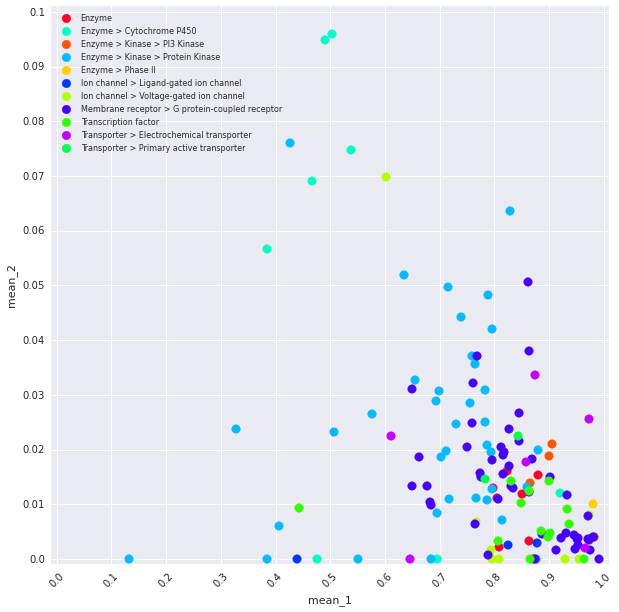

In [21]:
# Plot...

xcol, ycol = 'mean_1', 'mean_2'
                                                         
fig, axis = plt.subplots(1, 1, figsize=(10, 10))
    
points = [get_points(i, x) for i, x in enumerate(classes)]

xticks = np.arange(0, 1.1, 0.1)
axis.set_xlim(-0.01, 1.01)
axis.set_xticks(xticks)
axis.set_xticklabels(xticks, rotation=45)
axis.set_xlabel(xcol)

yticks = np.arange(0, 0.11, 0.01)
axis.set_ylim(-0.001, 0.101)
axis.set_yticks(yticks)
axis.set_yticklabels(yticks)
axis.set_ylabel(ycol)

axis.legend(points, classes, scatterpoints=1, loc='upper left', fontsize=8)

None

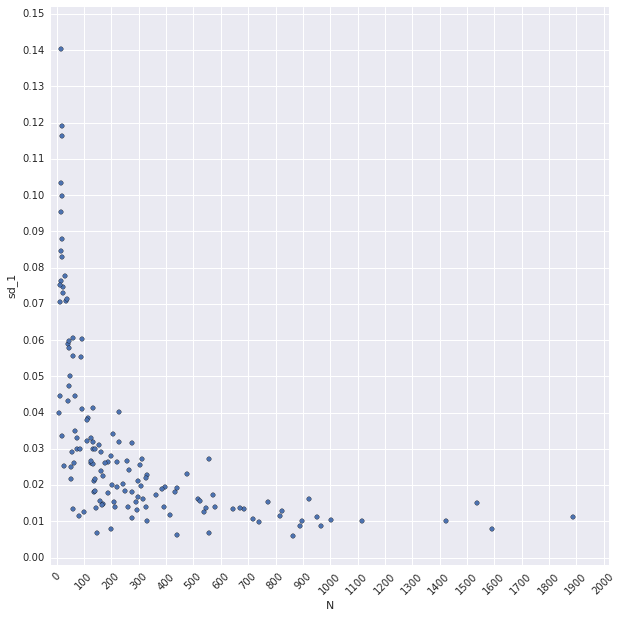

In [22]:
_ = summary.plot(x='N', y='sd_1', kind='scatter', xlim=(-20, 2020), xticks=np.arange(0, 2100, 100), rot=45, ylim=(-0.002, 0.152), yticks=np.arange(0, 0.151, 0.01), figsize=(10, 10))

In [23]:
summary.head()

,symbol,mean_1,sd_1,mean_2,sd_2,N,target_class
0,ABCB1,0.7827,0.023770,0.0146,0.011775,163,Transporter > Primary active transporter
1,ABCG2,0.8435,0.035018,0.0225,0.020402,67,Transporter > Primary active transporter
2,ABL1,0.6983,0.020160,0.0307,0.012736,241,Enzyme > Kinase > Protein Kinase
3,ACE,0.9830,0.012689,0.0040,0.006633,100,Enzyme
4,ACHE,0.8049,0.022919,0.0111,0.004482,476,Enzyme


In [24]:
# _ = summary.plot(figsize=(10, 10), kind='scatter', x='mean', y='sd', s=summary['N'])

## F-score

In [25]:
# Get true-positive and false-negative rate from prediction of actives...

def f(x):
    
    tp, n = x['predicted'].sum(), x['predicted'].size
    
    return pd.Series({'tp': tp/n, 'fn': (n - tp)/n})

# Get false-positive and true-negative rate from prediction of inactives...

def g(x):
    
    fp, n = x['predicted'].sum(), x['predicted'].size
        
    return pd.Series({'fp': fp/n, 'tn': (n - fp)/n})

# Get F1-score...

def h(x):
    
    return 2*x['tp']/(2*x['tp'] + x['fp'] + x['fn'])

# Get mean F1-scores for all runs...

f1_score = pd.concat([x.groupby('symbol').apply(f).merge(y.groupby('symbol').apply(g), left_index=True, right_index=True).apply(h, axis=1).to_frame('F1') for x, y in zip(all_results_1, all_results_2)], axis=1)\
    .apply(lambda x: x.mean(), axis=1).to_frame('F1')
    
# Add to summaryt table...

summary = summary.merge(f1_score, left_on='symbol', right_index=True)

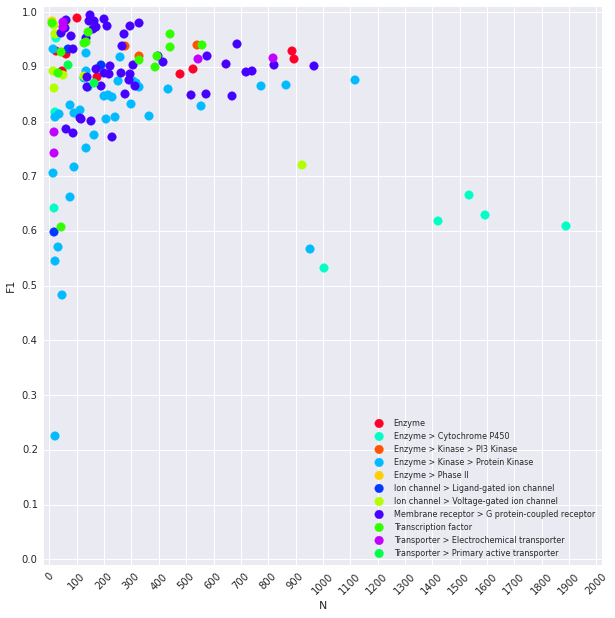

In [26]:
# Plot...

xcol, ycol = 'N', 'F1'
                                                         
fig, axis = plt.subplots(1, 1, figsize=(10, 10))
    
points = [get_points(i, x) for i, x in enumerate(classes)]

xticks = np.arange(0, 2100, 100)
axis.set_xlim(-20, 2020)
axis.set_xticks(xticks)
axis.set_xticklabels(xticks, rotation=45)
axis.set_xlabel(xcol)

yticks = np.arange(0, 1.1, 0.1)
axis.set_ylim(-0.01, 1.01)
axis.set_yticks(yticks)
axis.set_yticklabels(yticks)
axis.set_ylabel(ycol)

axis.legend(points, classes, scatterpoints=1, loc='lower right', fontsize=8)

None